In [1]:
!pip install opencv-python==3.4.0.12 -q
!pip install opencv-contrib-python==3.4.0.12 -q

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imread_collection
import skimage.io as io
from skimage import feature
from itertools import chain
%matplotlib inline

## Load training data

In [3]:
!wget https://s3.amazonaws.com/jrw-notebook-data/airplanes.tar

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!tar -xf airplanes.tar

In [2]:
# grab the files
import glob

totalNegative = (glob.glob('.\\airplanes\\negatives\\*.tif'))
totalPositive = (glob.glob('.\\airplanes\\positives\\*.tif'))
print "Positive Files: %s" %(len(totalNegative))
print "Negative Files: %s" %(len(totalPositive))

Positive Files: 873
Negative Files: 827


In [3]:
# sample for train - 80%
from random import sample

rand_positive = sample(totalPositive, 662)
rand_negative = sample(totalNegative, 662)

positives = imread_collection(rand_positive, conserve_memory=True)
negatives = imread_collection(rand_negative, conserve_memory=True)

In [4]:
# sample for test - 20%
rand_positive_test = sample([file for file in totalPositive if file not in rand_positive], 165)
rand_negative_test = sample([file for file in totalNegative if file not in rand_negative], 165)

positives_test = imread_collection(rand_positive_test)
negatives_test = imread_collection(rand_negative_test)

## Image examples

In [6]:
def plot(image, w=12, h=12, cmap='Greys'):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('off')
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.show()

#### Positive Image

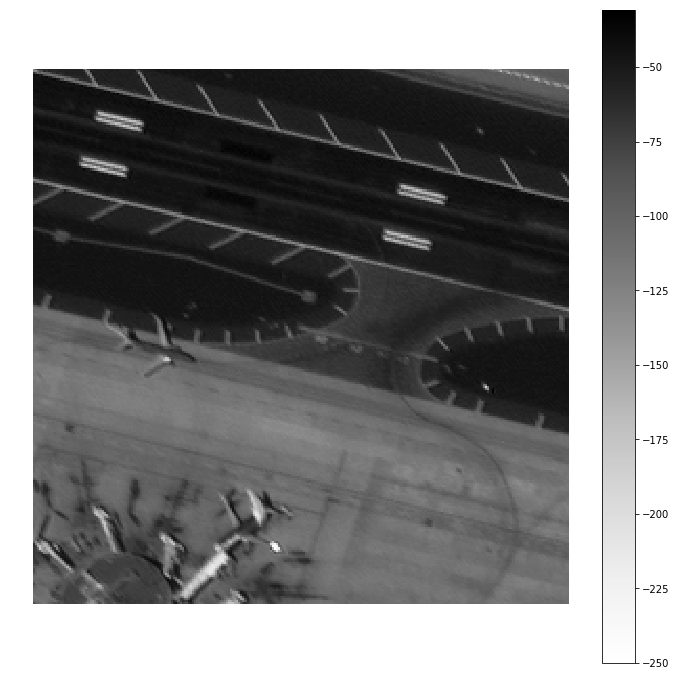

In [7]:
plot(positives[0]*-1)

#### Negative

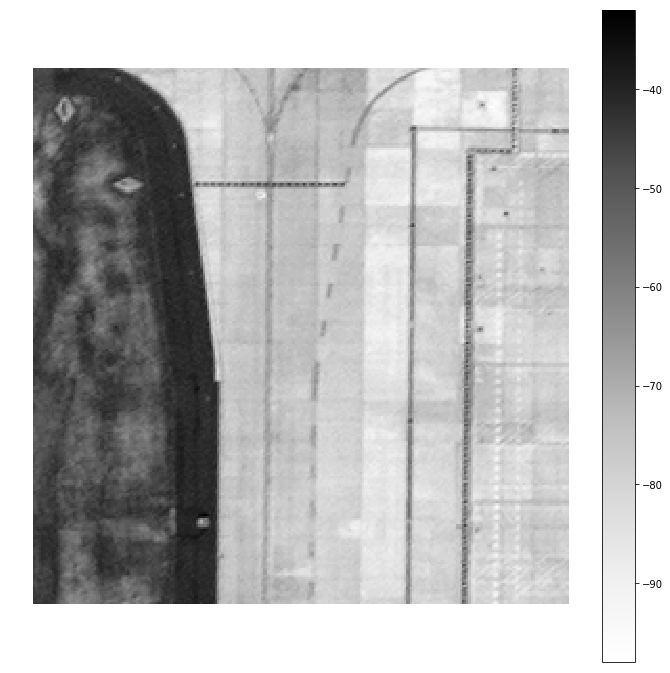

In [8]:
plot(negatives[0]*-1)

## Histogram Oriented Gradients

#### Positive

In [9]:
oink_vec, oink_vis = feature.hog(positives[1], visualize=True)

C:\Users\ailin\Anaconda3\envs\gbdxtools\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


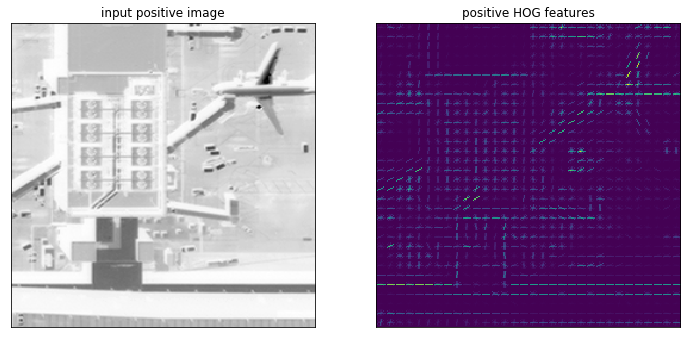

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(positives[1]*-1, cmap='gray')
ax[0].set_title('input positive image')

ax[1].imshow(oink_vis)
ax[1].set_title('positive HOG features');

#### Negative

C:\Users\ailin\Anaconda3\envs\gbdxtools\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


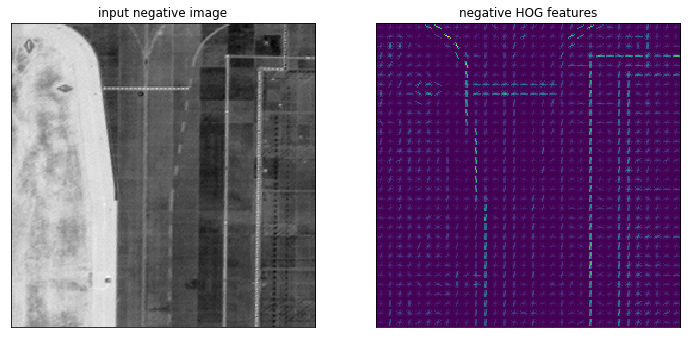

In [11]:
#compute some hog features, oink oink, again. 

oink_vec2, oink_vis2 = feature.hog(negatives[0], visualise=True)

#and look at these new features!

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(negatives[0]*-1, cmap='gray')
ax[0].set_title('input negative image')

ax[1].imshow(oink_vis2)
ax[1].set_title('negative HOG features');

## Saliency Detection (apply later?)

#### Positive

In [147]:
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(img_sift)
saliencyMap = (saliencyMap * 255).astype("uint8")
threshMap = cv2.threshold(saliencyMap, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


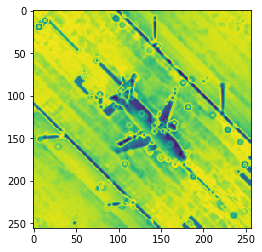

In [148]:
plt.imshow(saliencyMap)
plt.show()

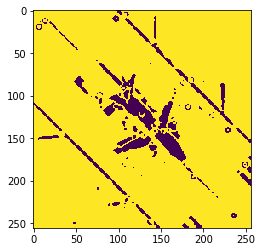

In [149]:
plt.imshow(threshMap)
plt.show()

# 1: Training!

## Create Features

In [14]:
## Generate Features for both training sets
X_train = np.array([feature.hog(im) for im in chain(positives,negatives)])

## Generate binary 1,0 classification for positive and negative
y_train = np.zeros(X_train.shape[0])
y_train[:np.array(positives).shape[0]] = 1

## Look at the dimensions of our training data
X_train.shape

(1324L, 72900L)

In [15]:
## Generate Features for both test sets
X_test = np.array([feature.hog(im) for im in chain(positives_test,negatives_test)])

## Generate binary 1,0 classification for positive and negative
y_test = np.zeros(X_test.shape[0])
y_test[:np.array(positives_test).shape[0]] = 1

## Look at the dimensions of our test data
X_test.shape

(330L, 72900L)

## Cluster! - Create Visual Words

In [16]:
from sklearn.cluster import KMeans

In [17]:
n_clusters = 100

In [18]:
km_model = KMeans(n_clusters=n_clusters, n_jobs=-1)

In [20]:
kmeans_ret = km_model.fit_predict(X_train)

In [21]:
kmeans_ret.shape

(1324L,)

In [27]:
kmeans_ret[4]

64

## Make Image feature Histograms

In [22]:
histograms = np.array([np.zeros(n_clusters) for i in range(int(X_train.shape[0]))]) # (rows=images x cols=codewords/clusters)

In [31]:
cnt = 0
for i in range(len(labels_train_clean)): #
    l = len(descriptors_train_clean[i])
    for j in range(l): #go thru each descriptor for each image
        idx = kmeans_ret[cnt+j]
        histograms[i][idx] += 1
    cnt += 1
        

### Normalize histogram

In [32]:
from sklearn.preprocessing import normalize, StandardScaler

In [33]:
# use L2 normalization along rows-> histogram of each img
# histograms_norm = normalize(histograms, norm='l2', axis=0)

In [34]:
# use standardize to normalize distribution
scale = StandardScaler().fit(histograms)
histograms_norm = scale.transform(histograms)

In [35]:
histograms_norm.shape

(1178L, 500L)

In [36]:
labels_train.shape

(1324L,)

In [37]:
histograms_norm

array([[-0.65015791, -0.46036307,  0.        , ..., -0.05837084,
         0.96605689, -0.38835801],
       [-0.65015791, -0.46036307,  0.        , ..., -0.05837084,
         0.96605689, -0.38835801],
       [-0.65015791, -0.46036307,  0.        , ..., -0.05837084,
         0.96605689, -0.38835801],
       ...,
       [-0.65015791, -0.46036307,  0.        , ..., -0.05837084,
        -0.75820829, -0.38835801],
       [-0.65015791, -0.46036307,  0.        , ..., -0.05837084,
        -0.75820829, -0.38835801],
       [-0.65015791, -0.46036307,  0.        , ..., -0.05837084,
        -0.75820829, -0.38835801]])

## Train SVM Classifier

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle

In [59]:
cross_val_score(SVC(kernel='linear', C=1), histograms_norm, labels_train_clean)

array([0.67, 0.94, 0.54])

In [41]:
X_train, X_val, y_train, y_val = train_test_split(histograms_norm, labels_train_clean, test_size=0.2, random_state=42, stratify=list(labels_train_clean))

In [42]:
svc_model = SVC(kernel='linear', C=1)

In [43]:
svc_model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
svc_model.score(X_val, y_val)

0.9872881355932204

In [45]:
### try shuffling whole thing to train model
X_tr, y_tr = shuffle(histograms_norm, labels_train_clean)

In [46]:
svc_model.fit(X_tr, y_tr)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# 2 Test

## Get Features

In [47]:
img_dict_test = {'positives': positives_test, 'negatives': negatives_test}

In [48]:
descriptors_test, labels_test = extractFeats(img_dict_test, name_dict)

In [49]:
#clean out any None types
descriptors_test_clean = [x for x in descriptors_test if x is not None]
labels_test_clean = [l for i, l in enumerate(labels_test) if descriptors_test[i] is not None]

In [50]:
test_stack = np.vstack(descriptors_test_clean)

In [51]:
X_test, y_test = shuffle(descriptors_test_clean, labels_test_clean)
#X_test, y_test = descriptors_test_clean, labels_test_clean

## Make Predictions

In [52]:
def makeprediction(feats, n_clusters=n_clusters, km=km_model, scale=scale, model=svc_model):
    #vocab for test image
    vocab = np.array([[0 for i in range(n_clusters)]])
    
    # return of kmeans nearest clusters for N features
    test_ret = km.predict(feats)
    
    for each in test_ret:
        vocab[0][each] += 1
    #print(vocab)
    
    #scale the features
    vocab = scale.transform(vocab)
    
    # predict the class of the image
    lb = model.predict(vocab)
    
    return lb[0]

In [53]:
pred_y = [makeprediction(x_t) for x_t in X_test]

C:\Users\ailin\Anaconda3\envs\gbdxtools\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [54]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [55]:
cnf_matrix = confusion_matrix(y_test, pred_y)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[68 67]
 [66 91]]


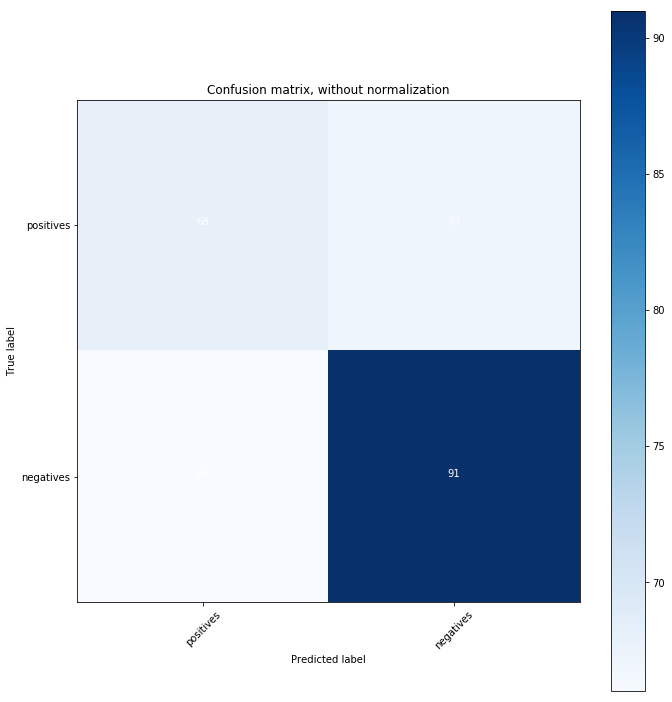

In [56]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=list(name_dict.keys()), title='Confusion matrix, without normalization')
plt.show()

### Accuracy measures

In [57]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
print "Accuracy = {:.2%}".format(accuracy_score(y_test, pred_y))
print "Precision = {:.2%}".format(precision_score(y_test, pred_y))
print "Recall = {:.2%}".format(recall_score(y_test, pred_y))

Accuracy = 54.45%
Precision = 57.59%
Recall = 57.96%


# 3 Try model over a new image

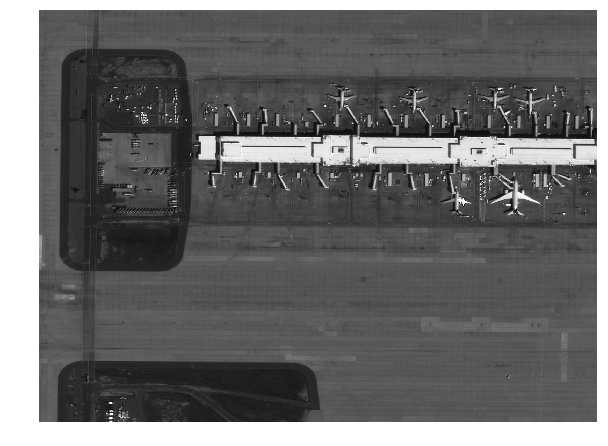

In [60]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '10300100454C9500')
bbox = env.inputs.get('bbox', '-104.68200445175172, 39.854937988531276, -104.6742582321167, 39.86065367273528')

dia_image = CatalogImage(catalog_id, band_type="Pan", bbox=map(float, bbox.split(",")))
dia_image.plot(w=10, h=10)

In [61]:
## define a sliding window function

def sliding_window(img, patch_size=[256,256],
                   istep=128, jstep=128, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

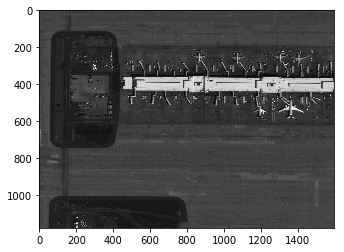

In [86]:
plt.imshow((dia_image[0,:,:].read()/256).astype('uint8'), cmap='gray')
plt.show()

In [87]:
## Generate features and indices 

windows = [t[1] for t in sliding_window((dia_image[0,:,:].read()/256).astype('uint8'),patch_size=[256,256])]
indices = [t[0] for t in sliding_window((dia_image[0,:,:].read()/256).astype('uint8'),patch_size=[256,256])]

In [90]:
descriptor_list = []
for img in windows:
    #print type(img)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    descriptor_list.append(descriptors)

In [99]:
descriptors_clean = [x for x in descriptor_list if x is not None]
indices_clean = [idx for i, idx in enumerate(indices) if descriptor_list[i] is not None]

In [100]:
pred_new = [makeprediction(x_t) for x_t in descriptors_clean]

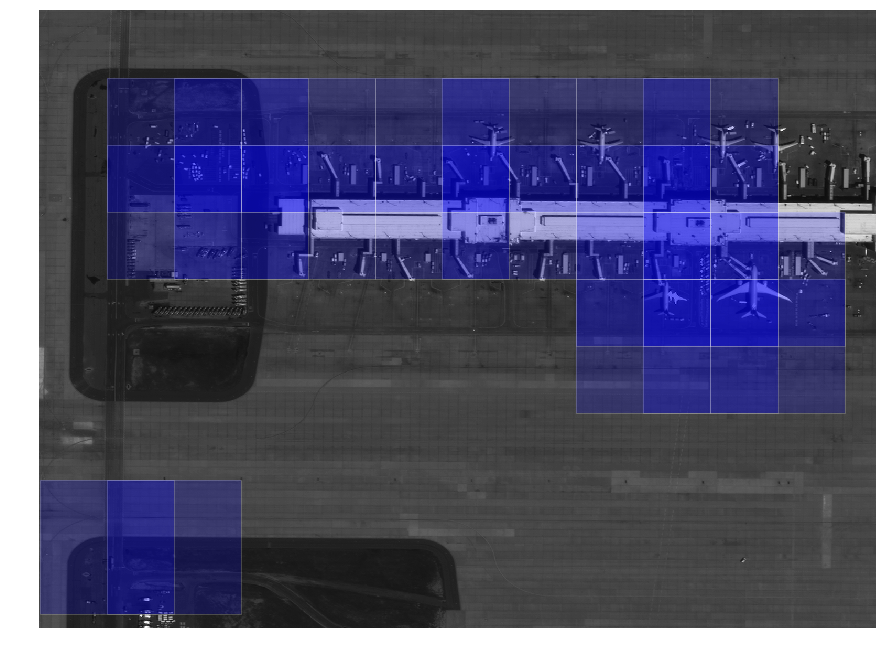

In [126]:
#plot the predictions:

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)    
ax.imshow(dia_image[0,:,:].read(), cmap='gray')
ax.axis('off')

Ni, Nj = [256,256]
indices = np.array(indices_clean)

for i, j in indices[np.array(pred_new) == 1.0]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='none',
                               alpha=0.2, lw=2, facecolor='red'))
    
for i, j in indices[np.array(pred_new) == 0.0]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='none',
                                alpha=0.2, lw=2, facecolor='blue'))

for i, j in indices:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='white',
                               alpha=0.2, lw=1, facecolor='none'))

Complete garbage!!!